In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import MonthLocator
from sklearn import tree

%matplotlib inline

filename_test = 'test.csv'
filename_train = 'train.csv'
filename_store = 'store.csv'

train = pd.read_csv(filename_train, header=0, low_memory=False)

test = pd.read_csv(filename_test, header=0, low_memory=False)


store = pd.read_csv(filename_store, header=0, low_memory=False)



In [2]:
train.Date = pd.to_datetime(train.Date)

test.Date = pd.to_datetime(test.Date)


In [3]:
def print_missing_stats():
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask].tolist())
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()
print_missing_stats()

TRAIN  (overall = 1017209)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Sales
    0 ( 0%) missing values in  Customers
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

TEST  (overall = 41088)
    0 ( 0%) missing values in  Id
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
   11 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

STORE  (overall = 1115)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  StoreType
    0 ( 0%) missing values in  Assortment
    3 ( 0%) missing values in  CompetitionDistance
  354 (31%) missing values in  CompetitionOpenSinceMonth
  354 (31%) missing values in  

### Filling missing values

In [4]:
# print(test[test.Open.isnull()])
test.ix[test.Open.isnull(), 'Open'] = 1

store.ix[store.CompetitionDistance.isnull(),
         'CompetitionDistance'] = store.CompetitionDistance.mean()
store.ix[store.CompetitionOpenSinceMonth.isnull(),
         'CompetitionOpenSinceMonth'] = int(store.CompetitionOpenSinceMonth.mode())
store.ix[store.CompetitionOpenSinceYear.isnull(),
         'CompetitionOpenSinceYear'] = int(store.CompetitionOpenSinceYear.mode())

print_missing_stats()

TRAIN  (overall = 1017209)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Sales
    0 ( 0%) missing values in  Customers
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

TEST  (overall = 41088)
    0 ( 0%) missing values in  Id
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

STORE  (overall = 1115)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  StoreType
    0 ( 0%) missing values in  Assortment
    0 ( 0%) missing values in  CompetitionDistance
    0 ( 0%) missing values in  CompetitionOpenSinceMonth
    0 ( 0%) missing values in  

### Plotting all sales by day of week and store

In [5]:
# fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

# for day_of_week in range(1, 8):
#     custom_df = train[(train['Open'] == 1) & (train['DayOfWeek'] == day_of_week)]
#     gp_store = custom_df.groupby('Store')

#     for store, group in gp_store:
#         axes[day_of_week - 1].plot(group['Date'], group['Sales'], 'v--')

#     gp_date = custom_df.groupby('Date')

#     ts_mean = gp_date['Sales'].mean()
#     ts_median = gp_date['Sales'].median()
#     ts_mean.plot(style='r-', linewidth=5, ax=axes[day_of_week - 1], label='mean')
#     ts_median.plot(style='b-', linewidth=5, ax=axes[day_of_week - 1], label='median')


#     axes[day_of_week - 1].set_title('Day ' + str(day_of_week) + '. number of stores = ' + str(len(gp_store)))
#     axes[day_of_week - 1].legend()
#     axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
#     axes[day_of_week - 1].grid(True)
# # pl.savefig('all_stores_and_median.png', format='png')
# del fig
# del axes

### Plotting mean of sales by day of week with different values of categorical features

In [6]:
# def construct_label_name(school_holiday, state_holiday, promo_flag, n_stores):
#     string_school = 'NO SchoolHoliday. '
#     string_state = 'NO StateHoliday. '
#     string_promo = 'NO Promo. '
#     if school_holiday == 1:
#         string_school = string_school[3:]
#     if promo_flag:
#         string_promo = string_promo[3:]
#     if state_holiday != '0':
#         string_state = {'a': 'PublicHoliday. ',
#                         'b': 'EasterHoliday. ',
#                         'c':'Christmas. '}[state_holiday]
#     string_stores = '(' + str(n_stores) + ' stores)'
#     return string_school + string_state + string_promo + string_stores

# fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))
# for day_of_week in range(1, 8):
#     for school_holiday in [0, 1]:
#         for state_holiday in ['0', 'a', 'b', 'c']:
#             for promo_flag in [0, 1]:
#                 custom_df = train[(train.Open == 1) & 
#                                   (train.DayOfWeek == day_of_week) &
#                                   (train.Promo == promo_flag) & 
#                                   (train.SchoolHoliday == school_holiday) & 
#                                   (train.StateHoliday == state_holiday)]

#                 gp_date = custom_df.groupby('Date')
#                 gp_store = custom_df.groupby('Store')
                
#                 if list(gp_date.Sales):
#                     ts_mean = gp_date.Sales.mean()
#                     ts_mean.plot(style='v--', ax=axes[day_of_week - 1], 
#                                  label=construct_label_name(school_holiday, state_holiday,
#                                                             promo_flag, len(gp_store)))
    
                
#     custom_df = train[(train.Open == 1) & (train.DayOfWeek == day_of_week)]
#     gp_date = custom_df.groupby('Date')
#     gp_store = custom_df.groupby('Store')
#     ts_mean = gp_date.Sales.mean()
#     ts_mean.plot(style='r-', linewidth=1.5, ax=axes[day_of_week - 1],
#                  label='mean (' + str(len(gp_store)) + ' stores)')
#     axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
#     axes[day_of_week - 1].legend()
#     axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
#     axes[day_of_week - 1].grid(True)
    
    
# # pl.savefig('median_decomposition.png', format='png')
# del fig
# del axes

### Training

In [110]:
data_train = []
data_train_labels = []

def get_mean_dict(custom_df):
    gb_date = custom_df.groupby('Date')
    return {'2013': gb_date.Sales.mean()['2013-01-01':'2013-12-31'], 
            '2014': gb_date.Sales.mean()['2014-01-01':'2014-12-31'], 
            '2015': gb_date.Sales.mean()['2015-01-01':'2015-07-31']}

n_stores = 30
stores_numbers = np.random.randint(1115, size=n_stores) + 1
# stores_numbers = range(1, 1116)
for store in stores_numbers:    
    print(store, end=' ')
    for day_of_week in range(1, 8):
        custom_df = train[(train.Open == 1) & (train.DayOfWeek == day_of_week)]
        custom_store_df = custom_df[custom_df.Store ==  store]
#         ts_week_mean = get_mean_dict(custom_df)
        ts_store_week_mean = get_mean_dict(custom_store_df)
        
        for school_holiday in [0, 1]:
            for promo_flag in [0, 1]:
                custom_df = train[(train.Open == 1) & 
                                  (train.DayOfWeek == day_of_week) &
                                  (train.Promo == promo_flag) & 
                                  (train.SchoolHoliday == school_holiday)]
                custom_store_df = custom_df[custom_df.Store ==  store]
                
#                 ts_mean = get_mean_dict(custom_df)
                ts_store_mean = get_mean_dict(custom_store_df)
                
                for year in ['2013', '2014']:
                    if len(ts_store_mean[year]):
                        for index, value in ts_store_week_mean[year].iteritems():
                            new_value = value
                            if index in ts_store_mean[year]:
                                 new_value = ts_store_mean[year][index]
                            data_train.append([store, index.year, index.month, index.day, promo_flag, 
                                               school_holiday, day_of_week])
                            data_train_labels.append(new_value)

data_train_labels = np.array(data_train_labels)
data_train = np.array(data_train)

1021 982 1071 733 1073 1058 847 1082 980 930 408 537 567 694 304 781 413 310 574 125 134 785 894 613 325 54 426 261 441 815 

### Constructing test

In [111]:
def construct_test(test):
    data_test = []
    for id, row in test.iterrows():
        data_test.append([row.Store, row.Date.year, row.Date.month, row.Date.day,
                          row.Promo, row.SchoolHoliday, row.DayOfWeek])
    return np.array(data_test)

date_range_2015 = pd.date_range('2015-01-01', '2015-12-31')

if n_stores < 1115:
    local_test = train[(train.Date.isin(date_range_2015)) & (train.Store.isin(stores_numbers))]
else:
    local_test = train[(train.Date.isin(date_range_2015))]

local_test_labels = np.asarray(local_test.Sales)

local_test = construct_test(local_test)

### Predicting

RMSPE = 21.7047309529


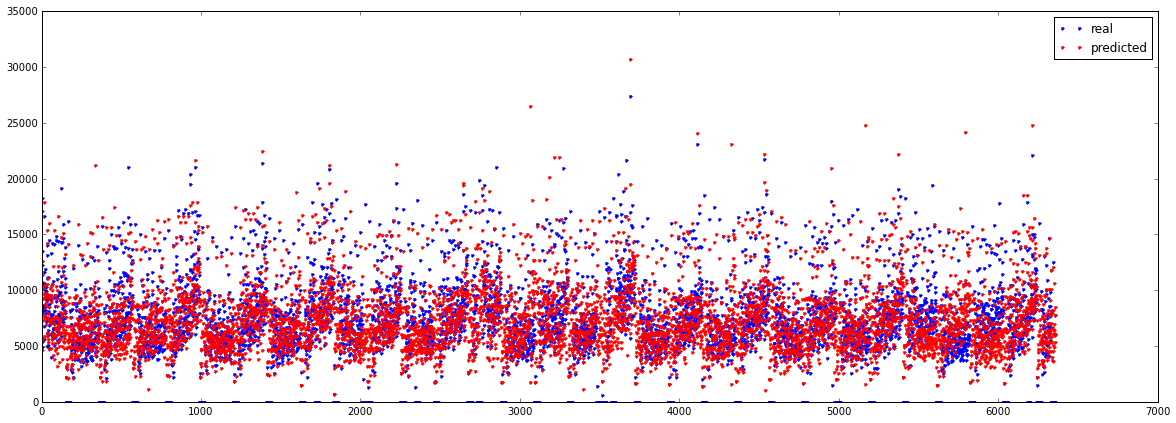

In [112]:
clf = tree.DecisionTreeRegressor()

clf.fit(data_train, data_train_labels)

predicted_test_labels = np.asarray(clf.predict(local_test), dtype=int) #CAUTION!

def compute_RMSPE(test_labels, predicted_labels):
    mask = test_labels.nonzero()
    if len(mask) == 0:
        return 0
    return np.sqrt(((np.ones(len(mask)) - predicted_test_labels[mask]/test_labels[mask])**2).sum()/len(mask))

loss_score = compute_RMSPE(local_test_labels, predicted_test_labels)
print('RMSPE =', loss_score)
pl.figure(figsize=(20,7))
pl.plot(local_test_labels, 'b.', label='real')
pl.plot(predicted_test_labels, 'r.', label='predicted')
pl.legend()
# data_test_labels = np.array(clf.predict(data_test), dtype=int) 

# test['Sales'] = data_test_labels

# test[['Id', 'Sales']].to_csv('prediction.csv', index=False)

### Plotting prediction (mean by stores) by day of week

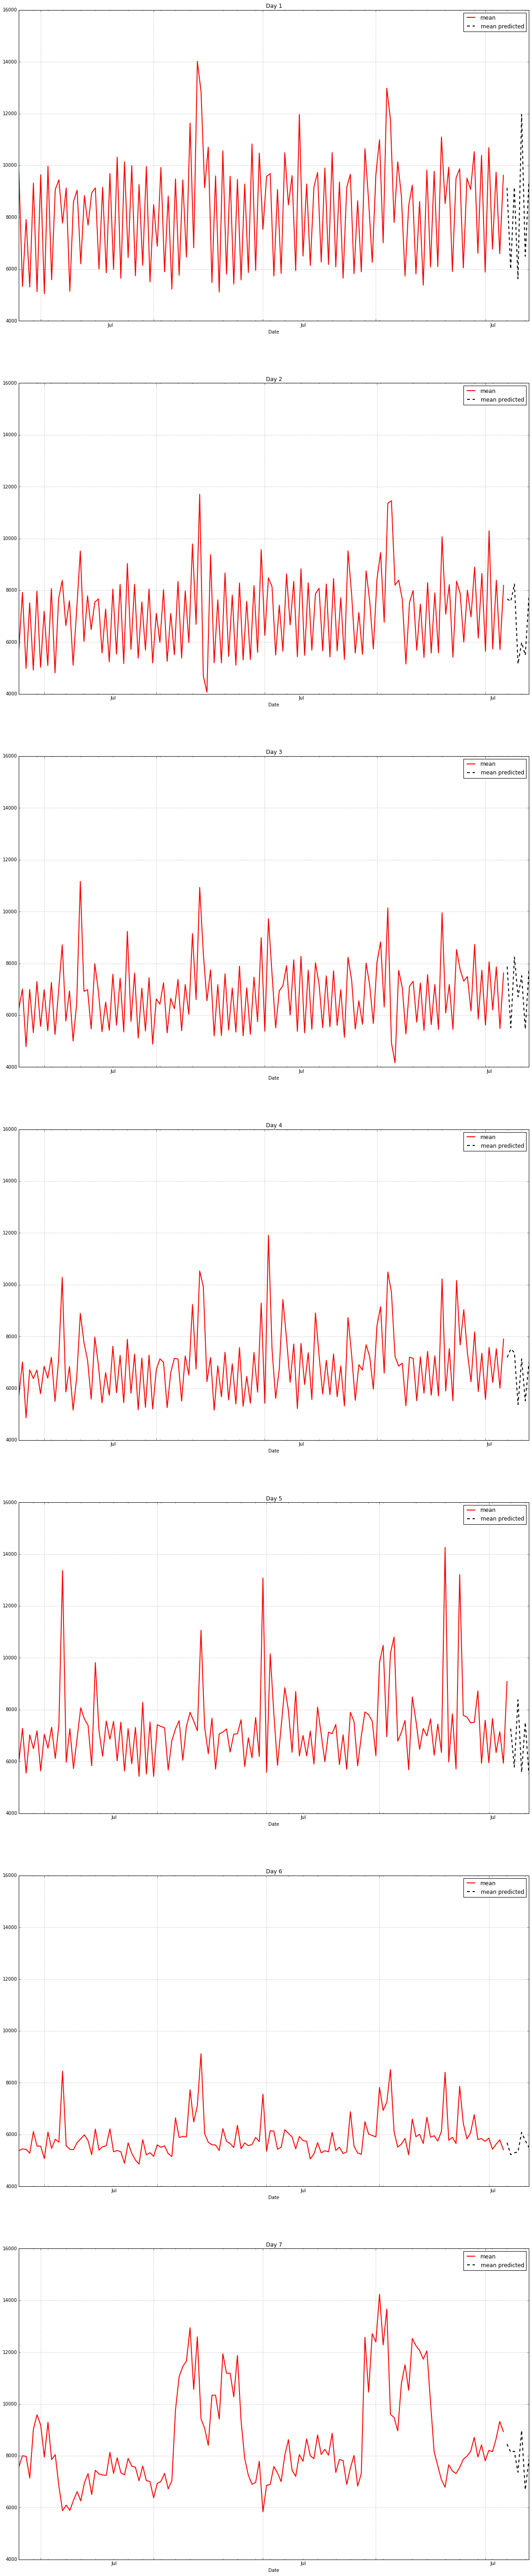

In [97]:
fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

for day_of_week in range(1, 8):
    custom_df = train[(train.Open == 1) & (train.DayOfWeek == day_of_week)]
    gp_date = custom_df.groupby('Date')

    ts_mean = gp_date.Sales.mean()
    ts_mean.plot(style='r-', linewidth=2, ax=axes[day_of_week - 1], label='mean')
    
    
    custom_df = test[(test.Open == 1) & (test.DayOfWeek == day_of_week)]
    gp_date = custom_df.groupby('Date')
    
    ts_mean = gp_date.Sales.mean()
    ts_mean.plot(style='k--', linewidth=2, ax=axes[day_of_week - 1], label='mean predicted')
    
    
    axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
    axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
    axes[day_of_week - 1].legend()
    axes[day_of_week - 1].grid(True)
    
del fig
del axes